# Measuring Cell Truncation

Many morphological cell-typing methods rely on dendritic and/or axonal features that require near complete cell reconstructions. While the automated segmentation is very impressive, most cells require extensive proofreading to reach the level of reconstruction needed for cell-typing. This notebook will walk through how we measured the levels of cell truncation due to segmentation errors and volume boundaries to illustrate the need for a truncation insensitive method for dataset wide cell-typing.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import caveclient
import scipy as sp
import matplotlib.pyplot as plt

# Volume Boundary Truncations

To estimate the percent of cells whose morphologies would be substantially truncated due to being near the volume boundaries, we measured the radial extent for a densely sampled subset of neurons. These cells were selected from an internal column of the dataset and include cells from Layer I - Layer VI. More details about these cells and the subsequent analysis can be found in the following manuscripts (Elabbady 2022 and Schneider-Mizell 2023) 

In [3]:
column_df = pd.read_feather('../data/column_radial_truncation_v795.feather')
column_df.head()

,root_id,radial_extent_dendrite,classification_system,cell_type,id
0,864691135570190726,147.441307,aibs_coarse_excitatory,L2c,256546
1,864691136619397005,111.716174,aibs_coarse_excitatory,L3a,258317
2,864691135737224836,154.055844,aibs_coarse_excitatory,L6wm,312015
3,864691135941715060,138.142983,aibs_coarse_excitatory,L6wm,347173
4,864691135476662696,117.010702,aibs_coarse_excitatory,L6tall-a,307222


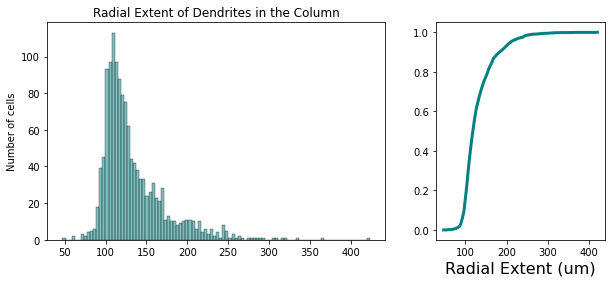

In [20]:

#Plotting a histogram of the radial extent of all the neurons in the column
f, ax = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(column_df.radial_extent_dendrite,bins=100,color='teal',alpha=0.5,ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of cells')
ax[0].set_title('Radial Extent of Dendrites in the Column')

#Calculating the cumulative distribution of these cells with respect to radial exent
all_vals = []  
vals, edges = np.histogram(column_df.radial_extent_dendrite, bins=100)
pdf = vals / sum(vals)   
cdf = np.cumsum(pdf)

#Plotting the cumulative distribution
ax[1].set_xlabel('Radial Extent (um)', size=16)    
ax[1].plot(edges[:-1], cdf, color='teal', linewidth=3)

plt.show()

Now let's look at how this compares to the rest of the rest of the cells in the dataset, irrespective of their reconstruction status

In [7]:
#Reading in the nucleus table with all the cells in the dataset
client = caveclient.CAVEclient('minnie65_phase3_v1')
nuc_df = client.materialize.query_table('nucleus_detection_v0',split_positions=True)
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661')

#Filtering out any error cells by selecting only those in the latest cell-type table
mm_ids = mm_df.id_ref.tolist()
nuc_df = nuc_df.query('id in @mm_ids')

In [9]:
#Converting our positions into nanometers
nuc_df['pt_position_z_nm'] = nuc_df.pt_position_z * 40
nuc_df['pt_position_x_nm'] = nuc_df.pt_position_x * 4
nuc_df['pt_position_y_nm'] = nuc_df.pt_position_y * 4

Detecting the volume boundaries in the Z axis is pretty straight forward as it defined defined by the first and last section collected and is consistent across the volume. However, the X axis is a little more nuanced since there can be a little jitter after all the sections have been realigned. To account for this, we binned the entire volume and took the average minimum and maximum in X as the volume edge for each bin.

In [21]:
res = 5000
min_z = nuc_df.pt_position_z_nm.min()
max_z = nuc_df.pt_position_z_nm.max() 

#Calculating the left edge of the volume for each bin
min_vol=sp.stats.binned_statistic(nuc_df.pt_position_z_nm, nuc_df.pt_position_x_nm,
 bins=np.arange(min_z, max_z,res), statistic='min')

#Calculating the right edge of the volume for each bin
max_vol=sp.stats.binned_statistic(nuc_df.pt_position_z_nm, nuc_df.pt_position_x_nm,
 bins=np.arange(min_z, max_z,res), statistic='max')

In [12]:
nuc_df['binnumber'] = min_vol.binnumber

Now that that's done, we can measure the minimum distance for each cell from the edges of the volume in X and Z.

In [13]:
#calculate the min z distance for each cell
back_dist = nuc_df.pt_position_z_nm - min_z
front_dist = max_z = nuc_df.pt_position_z_nm 

min_dist = []
for t in zip(back_dist,front_dist):
    back = t[0]
    front = t[1]
    if back <= front:
        min_dist.append(back)
    else:
        min_dist.append(front)
        
nuc_df['min_dist_z_nm'] = min_dist
nuc_df['min_dist_z'] = nuc_df['min_dist_z_nm']/1000

In [14]:
#calculate the min x distance for each cell
min_dist = []
for ix,i in nuc_df.iterrows():
    binnum = i.binnumber
    if binnum == 101:
        binnum=100
    minx = min_vol.statistic[binnum-1]
    maxx = max_vol.statistic[binnum-1]
    
    minx_dist = i.pt_position_x_nm - minx
    #if minx_dist < 0:
        #print('minx_dist!')
    maxx_dist = maxx = i.pt_position_x_nm 
    if minx_dist <= maxx_dist:
        min_dist.append(minx_dist)
    else:
        min_dist.append(maxx_dist)
        
nuc_df['min_dist_x_nm'] = min_dist
nuc_df['min_dist_x'] = nuc_df['min_dist_x_nm']/1000

To approximate how close each cell is, we will take the minimum distance to any of the four borders. So if one cell is very close to the left edge of the volume but centered with respect to Z, we will take the distance from that cell's soma to the left edge.

In [16]:
min_dist = []
for t in zip(nuc_df.min_dist_z,nuc_df.min_dist_x):
    z = t[0]
    x = t[1]
    if z <= x:
        min_dist.append(z)
    else:
        min_dist.append(x)
        
nuc_df['min_dist_border'] = min_dist

In [18]:
median_radius = column_df.radial_extent_dendrite.median() #to plot on top of the entire dataset

Now that we have the minimum distances from the border for each cell, let's compare how the distributions compare to the proofread column from above

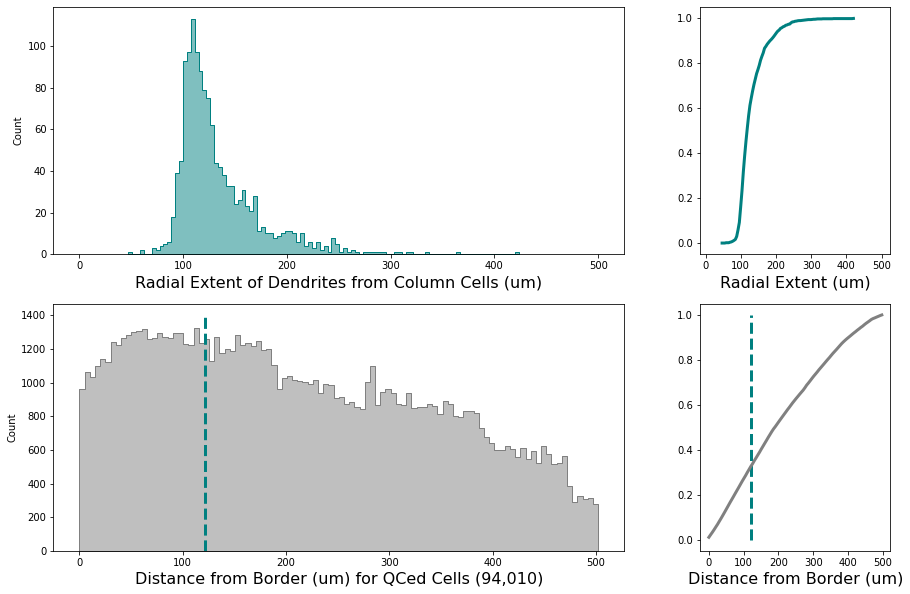

In [19]:
f, ax = plt.subplots(2,2,figsize=(15,10),gridspec_kw={'width_ratios': [3, 1]})

#Replotting the column histogram from above
sns.histplot(column_df.radial_extent_dendrite,bins=100,color='teal',
             element="step", fill=True,
             alpha=0.5,ax=ax[0,0])
ax[0,0].set_xlabel('Radial Extent of Dendrites from Column Cells (um)', size=16)    
ax[0,0].set_xlim((-25,525)) 

#Plotting a histogram of distances from the border across the dataset
sns.histplot(nuc_df.min_dist_border,bins=100,color='gray',
             element="step", fill=True,
             alpha=0.5,ax=ax[1,0])
ax[1,0].set_xlabel('Distance from Border (um) for QCed Cells (94,010)', size=16)    
ax[1,0].vlines(x=median_radius, ymin=0, ymax=1400, colors='teal', ls='--', lw=3)

#Replotting the column cumulative data from above
all_vals = []  
vals, edges = np.histogram(column_df.radial_extent_dendrite, bins=100)
pdf = vals / sum(vals)   
cdf = np.cumsum(pdf)
ax[0,1].set_xlabel('Radial Extent (um)', size=16)    
ax[0,1].plot(edges[:-1], cdf, color='teal', linewidth=3)
ax[0,1].set_xlim((-15,525)) 

#Plotting the cumulative distances across the dataset
all_vals = []  
vals, edges = np.histogram(nuc_df.min_dist_border, bins=100)
pdf = vals / sum(vals)   
cdf = np.cumsum(pdf)
ax[1,1].set_xlabel('Distance from Border (um)', size=16)    
ax[1,1].plot(edges[:-1], cdf, color='gray', linewidth=3)
ax[1,1].vlines(x=median_radius, ymin=0, ymax=1, colors='teal', ls='--', lw=3)

plt.show()

# Segmentation Errors